# Text Classification
Code for classifying passages in legal clause types using bert model.

Input csv file link given below(contains data points given in the problem statement along with some more data points that I got from law insider website(https://www.lawinsider.com/clauses))

https://drive.google.com/file/d/1CkrEBk3eXIZr5jMd5AMsuvk-Mq3SiFDC/view?usp=sharing

Test csv file(contains 10 test points given in the problem statement)
         https://drive.google.com/file/d/1t1ZGDsiVZb8laJD1YeO-HWxfHLLNZjX4/view?usp=sharing




In [ ]:
# Installing the transformers library(backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration between them)
!pip install -q transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 36.0 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 895 kB 48.4 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 


In [ ]:
# Importing ML libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig, AutoTokenizer, AutoModel, AutoConfig

In [ ]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# Upload your input dataset here as a csv file(The dataset is the one given in the problem statement along with some that I found from the internet(lawinsider.com))
from google.colab import files
uploaded = files.upload()

Saving inputs_final.csv to inputs_final.csv
Saving output_final.csv to output_final.csv


In [ ]:
#Reading uploaded input fle
df_ours = pd.read_csv("inputs_final.csv")

In [ ]:
#Creating one-hot encoding vectors
df_dum = pd.get_dummies(df_ours.Type)
df_dum.head()

,Governing Law,Indemnification,Lender Defaulting,Other,Preamble
0,0,0,0,0,1
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [ ]:
#Converting into lists
df_ours['list'] = df_dum[df_dum.columns[:]].values.tolist()
df_ours.head()

,Statement,Type,list
0,This CREDIT AGREEMENT is entered into as of No...,Preamble,"[0, 0, 0, 0, 1]"
1,This agreement is dated 22 December 2014 and m...,Preamble,"[0, 0, 0, 0, 1]"
2,This Agreement and shall be governed by and in...,Governing Law,"[1, 0, 0, 0, 0]"
3,The choice of South African law as the governi...,Governing Law,"[1, 0, 0, 0, 0]"
4,This agreement and other loan documents shall ...,Governing Law,"[1, 0, 0, 0, 0]"


In [ ]:
new_df = df_ours[['Statement', 'list']].copy()
new_df.head()

,Statement,list
0,This CREDIT AGREEMENT is entered into as of No...,"[0, 0, 0, 0, 1]"
1,This agreement is dated 22 December 2014 and m...,"[0, 0, 0, 0, 1]"
2,This Agreement and shall be governed by and in...,"[1, 0, 0, 0, 0]"
3,The choice of South African law as the governi...,"[1, 0, 0, 0, 0]"
4,This agreement and other loan documents shall ...,"[1, 0, 0, 0, 0]"


In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 1
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = AutoTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
#The CustomDataset class is used to create 2 datasets, for training and for validation.Training Dataset is used to fine tune the model: 80% of the original data
#Validation Dataset is used to evaluate the performance of the model. The model has not seen this data during training.
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Statement
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        # print(comment_text)
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
# Creating the dataset and dataloader for the neural network
train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
# test_dataset = test_final
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (75, 2)
TRAIN Dataset: (60, 2)
TEST Dataset: (15, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Fine tuning of pretrained bert model
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained('nlpaueb/legal-bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 5)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict = False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [ ]:
#Defining function for training
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
#Training the model
for epoch in range(100):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  0.18179577589035034
Epoch: 1, Loss:  0.14568422734737396
Epoch: 2, Loss:  0.15216509997844696
Epoch: 3, Loss:  0.15038900077342987
Epoch: 4, Loss:  0.1361878365278244
Epoch: 5, Loss:  0.12228309363126755
Epoch: 6, Loss:  0.12800145149230957
Epoch: 7, Loss:  0.11281704157590866
Epoch: 8, Loss:  0.12725259363651276
Epoch: 9, Loss:  0.11450493335723877
Epoch: 10, Loss:  0.09294534474611282
Epoch: 11, Loss:  0.10455603897571564
Epoch: 12, Loss:  0.10118770599365234
Epoch: 13, Loss:  0.09058540314435959
Epoch: 14, Loss:  0.08356016874313354
Epoch: 15, Loss:  0.08998686075210571
Epoch: 16, Loss:  0.07430525124073029
Epoch: 17, Loss:  0.08446069806814194
Epoch: 18, Loss:  0.07367586344480515
Epoch: 19, Loss:  0.06260696053504944
Epoch: 20, Loss:  0.07953349500894547
Epoch: 21, Loss:  0.06394964456558228
Epoch: 22, Loss:  0.051984429359436035
Epoch: 23, Loss:  0.05697900056838989
Epoch: 24, Loss:  0.0628238096833229
Epoch: 25, Loss:  0.06239546462893486
Epoch: 26, Loss:  0.054

In [ ]:
#Validating the model on splitted dataset
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    target_nums = []
    output_nums = []

    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            # import pdb; pdb.set_trace()
            class_number = torch.argmax(outputs)
            target_class = torch.argmax(targets)
            target_nums.append(target_class.item())
            output_nums.append(class_number.item())
            # print(ids)
            # print(outputs)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets, output_nums, target_nums

In [ ]:
#Validating the model on splitted dataset
def validation_on_train(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    target_nums = []
    output_nums = []

    with torch.no_grad():
        for _, data in enumerate(training_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            # import pdb; pdb.set_trace()
            class_number = torch.argmax(outputs)
            target_class = torch.argmax(targets)
            target_nums.append(target_class.item())
            output_nums.append(class_number.item())
            # print(ids)
            # print(outputs)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets, output_nums, target_nums

In [ ]:
#Printing accuracy score
for epoch in range(EPOCHS):
    outputs, targets, output_class, target_class = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy*100.00}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy Score = 90.0
F1 Score (Micro) = 0.9473684210526316
F1 Score (Macro) = 0.9333333333333332


In [ ]:
#Printing confusion matrix and precision value
from sklearn import metrics
# print(target_class)
# print(output_class)
confusion_matrix = metrics.confusion_matrix(target_class, output_class, labels=[0, 1, 2, 3, 4])
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
print("Precision: ", np.mean(precision))
print("Recall: ", np.mean(recall))

print(confusion_matrix)

Precision:  0.9
Recall:  0.9
[[3 0 0 0 0]
 [0 1 0 1 0]
 [0 0 3 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

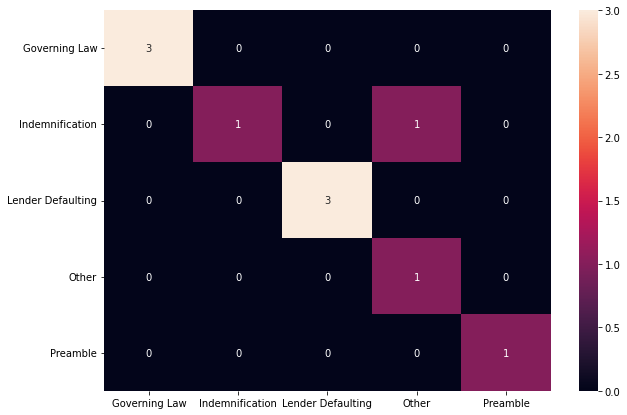

In [ ]:
classes = ["Governing Law", "Indemnification", "Lender Defaulting", "Other", "Preamble"]
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
#Upload the test dataset here as a csv file
from google.colab import files
uploaded = files.upload()

In [ ]:
#Read the uploaded file
df_out = pd.read_csv("output _final.csv")

In [ ]:
df_out.head() 

,Statement,Type
0,"Amendment No. 1 dated as of February 4, 2016 (...",Preamble
1,"Subject to the Legal Reservations, (a) the cho...",Governing Law
2,"This Agreement, and any non-contractual obliga...",Governing Law
3,Each Lender agrees to indemnify the Administra...,Indemnification
4,Any Lender that (a) has failed to (i) fund all...,Lender Defaulting


In [ ]:
#Creating one-hot encoding
dum_out = pd.get_dummies(df_out.Type)
dum_out

,Governing Law,Indemnification,Lender Defaulting,Other,Preamble
0,0,0,0,0,1
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0
5,1,0,0,0,0
6,0,1,0,0,0
7,0,0,1,0,0
8,0,0,0,1,0
9,0,0,1,0,0


In [ ]:
#Converting the list
df_out['list'] = dum_out[dum_out.columns[:]].values.tolist()
df_out.head()

,Statement,Type,list
0,"Amendment No. 1 dated as of February 4, 2016 (...",Preamble,"[0, 0, 0, 0, 1]"
1,"Subject to the Legal Reservations, (a) the cho...",Governing Law,"[1, 0, 0, 0, 0]"
2,"This Agreement, and any non-contractual obliga...",Governing Law,"[1, 0, 0, 0, 0]"
3,Each Lender agrees to indemnify the Administra...,Indemnification,"[0, 1, 0, 0, 0]"
4,Any Lender that (a) has failed to (i) fund all...,Lender Defaulting,"[0, 0, 1, 0, 0]"


In [ ]:
test_final = df_out[['Statement', 'list']].copy()
test_final.head()

,Statement,list
0,"Amendment No. 1 dated as of February 4, 2016 (...","[0, 0, 0, 0, 1]"
1,"Subject to the Legal Reservations, (a) the cho...","[1, 0, 0, 0, 0]"
2,"This Agreement, and any non-contractual obliga...","[1, 0, 0, 0, 0]"
3,Each Lender agrees to indemnify the Administra...,"[0, 1, 0, 0, 0]"
4,Any Lender that (a) has failed to (i) fund all...,"[0, 0, 1, 0, 0]"


In [ ]:
test_params = {'batch_size': 1,
                'num_workers': 0
                }
print("TEST Dataset: {}".format(test_final.shape))

# training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set_val = CustomDataset(test_final, tokenizer, MAX_LEN)

TEST Dataset: (10, 2)


In [ ]:
testing_loader = DataLoader(testing_set_val, **test_params)

In [ ]:
def validation_test(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            # targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [ ]:
#Predictions and confidence score
classes = ["Governing Law", "Indemnification", "Lender Defaulting", "Other", "Preamble"]
predictions = []
i = 0
for epoch in range(1):
    outputs = validation_test(epoch)
    # import pdb; pdb.set_trace()
    # print(outputs)
    for o in outputs:
        max_index = np.argmax(o)
        # print(o)
        confidence_score = o[max_index] * 100
        print(classes[max_index], " | Confidence score: ", confidence_score, "%")
        predictions.append([test_final.Statement[i], classes[max_index], confidence_score])
        i = i+1

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Preamble  | Confidence score:  95.08957266807556 %
Governing Law  | Confidence score:  97.11329936981201 %
Governing Law  | Confidence score:  98.80357384681702 %
Indemnification  | Confidence score:  97.13850021362305 %
Lender Defaulting  | Confidence score:  96.04560732841492 %
Governing Law  | Confidence score:  98.50859642028809 %
Other  | Confidence score:  35.61660647392273 %
Lender Defaulting  | Confidence score:  86.97175979614258 %
Other  | Confidence score:  97.2542941570282 %
Lender Defaulting  | Confidence score:  97.68990874290466 %


In [ ]:
#Saving the predictins with confidence socre in a JSON file
import json
with open('predictions.json', 'w') as f:
    json.dump(predictions, f)